# Expectation Maximization - Gaussian Mixture Model & K-mean Clustering

## Overview
This is a pet project where I trained a mixture of Gaussians (Gaussian Mixture Model) to represent an image and segment it according to the simplified representation. The model is trained with expectation-maximization.

**Note:** To have a better understanding of the algorithms, only NumPy package is used, nothing from scikit-learn is called. It's also a good **vectoration experiement** since the project requires huge volume of data manipulcation/calculation, multi-layer matrix manipulation (k x m x n) is impletmented.

In details, the project consists of following steps: 
1. [Warm-up] Implement k-means clustering to segment a color image.
2. Construct a Gaussian mixture model to be trained with expectation-maximization.
3. Improve the performance of Gaussian mixture model by 1) Use K-means algo to fasten the initialization step; 2) Try other convergence condition.

**Result Preview**: 

Image segamentation with K-mean Clustering (results with different K is shown below):

![bird_color](images/bird_all4.png)





<br>

- - -

## 1. K-means Clustering

As a warm-up, k-means clustering is an easy method to do image segmentation. It simply clusters all similar data points together and then replace with the mean value. **Vectorization is need!**

### Steps: 
1. K-means Clustering - 2D dataset & its visualization (interative charts provided)
2. K-means Clustering - Image Segmentation & its visualization

`get_initial_means()`: Calculate initial cluster means by selecting k number of points from the data (without replacement)

`k_means_step()`: A single update/step of the K-means algorithm


In [2]:
%load_ext autoreload
%autoreload 2

# Load all necessary modules
from IPython.html.widgets import *
import matplotlib.pyplot as plt
import os
import numpy as np
import time as time
from helper_functions import *

def get_initial_means(array, k):
    """
    Select k random points from the input array (without replacement) to use as initial cluster means

    params:
    array (np.ndarray): datapoints x features
    k (int): number of random points

    returns:
    initial_means (np.ndarray)
    """

    idx_row = np.arange(array.shape[0])
    np.random.shuffle(idx_row)
    
    return array[idx_row[:k], :]


def k_means_step(X, k, means):
    """
    A single update/step of the K-means algorithm. Based on input X and current mean estimate
    , calculate new means & predict clusters for each of the pixel
    
    params:
    X (numpy.ndarray): pixels x features (flattened)
    k (int)
    means (numpy.ndarray): k x features

    returns:
    new_means (numpy.ndarray): k x features
    clusters (numpy.ndarray):  m (vector)
    """

    # Calc the distance of all data points to each mean
    dist_all = [np.sqrt(np.sum(np.square(X - mean_i), axis=1)) for mean_i in means]
                        
    # Calc the argmin of all distances for each data point
    clusters = np.argmin(np.array(dist_all), axis=0)
    
    # Calc new means
    new_means = np.array([np.mean(X[clusters == uniq], axis=0) for uniq in np.unique(clusters)])
    
    return new_means, clusters


D:\Softwares\Continuum\anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### 1. K-means Clustering - 2D dataset (warm-up!)

In [3]:
def K_means_2D_dataset(dataset_index, K):
    """
    Load dataset from the /data folder and keep the training trajectory for later illustration purpose
    """
    
    # Load the dataset from data folder
    X = np.loadtxt("data/%d_dataset_X.csv" % dataset_index, delimiter=",")
    print("The dataset is of a size:", X.shape)

    # Load the labels
    # Clustering is unsupervised method, where no labels are provided
    # However, load them for illustration purposes.
    y = np.int16(np.loadtxt("data/%d_dataset_y.csv" % dataset_index, delimiter=","))

    # Runs for n_iterations before terminating
    n_iterations = 10
    m,n = X.shape
    means = get_initial_means(X,K)
    clusters = np.zeros([n])
    
    # Keep track of how clusters and means changed, for visualization purposes
    means_history = [means]
    clusters_history = [clusters] 
    for iteration_i in range(n_iterations):
        means, clusters = k_means_step(X, K, means)
        clusters_history.append(clusters)

    return X, y, means_history, clusters_history


# Use an interactive cell to see the progress of training the K-means algorithm
def get_cluster(i):
    # Get the clusters from K-means' i-th iteration
    clusters = clusters_history[i] 
    
    # Plot
    plt.figure(None, figsize=(15,6)) 
    plt.suptitle('Drag the slider to see the algorthm training progress')
    ax1=plt.subplot(1, 2, 1)
    ax1.set_title('K-means clsuters - step %d' % i)
    
    for k in range(K):
        plt.plot(X[clusters==k,0], X[clusters==k,1], '.') # 

    # The truth clusters
    ax2=plt.subplot(1, 2, 2)
    ax2.set_title('The truth clusters')
    for i in np.unique(y):
        ax2.plot(X[y==i,0],X[y==i,1],'.')

    plt.show()

In [8]:
##### Visualization of K-means Clustering - 2D dataset #####
# Select dataset and set K-param for K-mean clustering
dataset_index = 1 
K = 3

# Get the data
X, y, means_history, clusters_history = K_means_2D_dataset(dataset_index, K)

# Interactive plot
interactive(get_cluster, i=(1,len(clusters_history)-1,1))

The dataset is of a size: (1000, 2)


interactive(children=(IntSlider(value=5, description='i', max=10, min=1), Output()), _dom_classes=('widget-int…

### 2. K-means Clustering - Image Segmentation 
2D data clustering is just a warm-up! Now it's time play with K-means for real image segementation!

`k_means_segment()`: Separate the provided RGB values into k clusters using the k-means algorithm, then return an updated version of the image with the original values replaced with the corresponding cluster center values.

Convergence test: Whether the assigned clusters stop changing (this convergence test could be slow...). Initial cluster means are provided if empty.

For visualization purpose, color image data: `bird_color_24.png` is used. It's a multidimensional data with **rows x columns x color_channels**


In [9]:
def k_means_segment(image_values, k=3, initial_means=None):
    """
    Separate the provided RGB values into k separate clusters using the k-means algorithm,
    then return an updated version of the image with the original values replaced with
    the corresponding cluster values.

    params:
    image_values (numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]): rows x columns x color_channels
    k = int
    initial_means (numpy.ndarray[numpy.ndarray[float]] or None)

    returns:
    updated_image_values (numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]])
    """

    # Flatten the image_value - reshape
    height, width, depth = image_values.shape
    image_values = image_values.reshape(height * width, depth)
    
    if initial_means is None:
        means = get_initial_means(image_values, k)
    else:
        means = initial_means
    
    diff_cls = 100
    clusters = np.zeros(image_values.shape[0])
    
    # Convergence test - no diff in clustering 
    while diff_cls != 0: 
        clusters_prev = clusters.copy()   # copy is needed!
        means, clusters = k_means_step(image_values, k, means)
        diff_cls = np.sum(clusters_prev - clusters)
    
    # Another convergence test - iteration depth
#     itr = 0
#     while itr <= iter_depth:
#         means, clusters = k_means_step(image_values, k, means)
#         itr += 1
        
    # Return updated image - use mean to represent each cluster
    image_values_cp = image_values.copy()
    for uniq in np.unique(clusters):
        image_values_cp[clusters==uniq] = means[uniq]
    
    image_values_cp = image_values_cp.reshape(height, width, depth)
    
    return image_values_cp


Time took 0.43111 seconds to converge for K=3.
Time took 0.91791 seconds to converge for K=5.
Time took 1.70749 seconds to converge for K=8.
Time took 3.22172 seconds to converge for K=12.


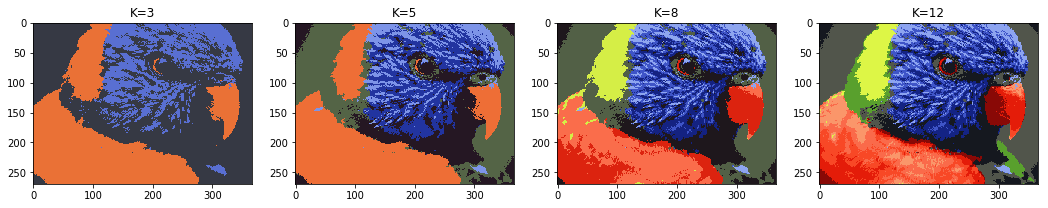

In [10]:
##### Visualization of K-means Clustering - Image Segmentation #####
# Let's test for diff combination of K:
K_all = [3, 5, 8, 12]
plt.figure(None,figsize=(18, 8))
image_values = image_to_matrix('images/bird_color_24.png')

for i in range(len(K_all)):
    K = K_all[i]
    tic = time.time()
    
    new_image = k_means_segment(image_values, k=K)
    axi = plt.subplot(1,4,i+1)
    axi.set_title('K=%d' % K)
    axi.imshow(new_image)
    
    toc = time.time()
    print('Time took %.5f seconds to converge for K=%d.' % ((toc-tic), K))

plt.savefig("bird_all4.png", bbox_inches='tight')
plt.show()   

## 2. Construct a Multivariate Gaussian Mixture Model (GMM)

**Some resources on GMM: **
1. `resources/gaussians.pdf`, `resources/Mixture-Models-and-EM_Bishop.pdf`
2. Youtube video by Alexander Ihler:https://www.youtube.com/watch?v=qMTuMa86NzU

- - -

Now it's time to play! 

**Steps to implemente a Multivariate Gaussian Expectation Maximization algorithm:**

1. Calculate the probability of a given data point (e.g. rgb value of a pixel) of belonging to a specific Gaussian component.
2. Use expectation-maximization (EM) to train the model to represent the image as a mixture of Gaussians.
3. Calculate the log likelihood of the trained model.
4. Segment the image according to the trained model.
5. Determine the best segmentation by iterating over model training and scoring, since EM isn't guaranteed to converge to the global maximum.

To initialize EM, set each component's mean to the means value of randomly chosen pixels (same as for K-means) and calculate covariances based on the selected means, and set the mixing coefficients to a uniform distribution. 

**Convergence test:** If the new likelihood is within 10% of the previous likelihood for 10 consecutive iterations, the model has converged.

**Highlight:** To have a better understanding of EM / GMM, only **Numpy** is used to accomplish this. Vectorization is implemented.


**Functions get impletmented/modulized as following: **
1. `initialize_parameters`
2. `prob`
3. `E_step` (vectorization required)
4. `M_step` (vectorization required)
5. `likelihood`
6. `train_model`
7. `cluster`
8. `segment`
9. `best_segment`


In [11]:
def initialize_parameters(X, k):
    """
    Return initial values for training of the GMM
    Set component mean to a random
    pixel's value (without replacement),
    based on the mean calculate covariance matrices,
    and set each component mixing coefficient (PIs)
    to a uniform values
    (e.g. 4 components -> [0.25,0.25,0.25,0.25]).
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    
    returns:
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1 
    """
    
    row, col = X.shape
    
    # Select k random pixels as initial means 
    # shuffle the idx instead of X itself will save a copy of X!
    idx = np.arange(row)
    np.random.shuffle(idx)
    MU = X[idx[:k], :]
    
    # Calc cov matrix based on random selected means
    SIGMA = np.zeros((k, col, col))
    for k_i in range(k):
        SIGMA[k_i, :, :] = (1/row) * np.matmul((X - MU[k_i]).T, (X - MU[k_i]))
    
    # Calc PI
    PI = np.repeat(1/k, k)
    
    return MU, SIGMA, PI
    
    
def prob(x, mu, sigma):
    """Calculate the probability of a single
    data point x under component with
    the given mean and covariance.
    # NOTE: there is nothing to vectorize here yet,
    # it's a simple check to make sure you got the
    # multivariate normal distribution formula right
    # which is given by N(x;MU,SIGMA) above

    params:
    x = numpy.ndarray[float]
    mu = numpy.ndarray[float]
    sigma = numpy.ndarray[numpy.ndarray[float]]

    returns:
    probability = float
    """
    
    # Modifty this function to handle vector input of x!
    # Need to expand dim if input is a single 1*n
    if len(x.shape) == 1:
        x = np.expand_dims(x, axis=0)
    
    row, col = x.shape
    det_cov = np.linalg.det(sigma)
    norm_coef = 1 / (np.sqrt(np.power(2 * np.pi, col) * det_cov))
    
    x_mu = x - mu
    inv_cov = np.linalg.inv(sigma)
    norm_main = np.sum(np.multiply(np.dot(x_mu, inv_cov), x_mu), axis=1) # this is the vectorization (not optimal...)
    norm_exp = np.exp((-0.5) * norm_main)
    
    norm_pdf = norm_coef * norm_exp
    
    # Output has to be float if input x is 1*n, otherwise, output is vector m*n
    if row == 1:
        return norm_pdf[0]
    else:
        return norm_pdf    
    

In [12]:
def E_step(X,MU,SIGMA,PI,k):
    """
    E-step - Expectation 
    Calculate responsibility for each
    of the data points, for the given 
    MU, SIGMA and PI.
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1
    k = int
    
    returns:
    responsibility = numpy.ndarray[numpy.ndarray[float]] - k x m
    """
    
    row, col = X.shape
    ri = np.zeros((k, row))
    
    # Calc Norm pdf of each datum for each cluster k
    for ki in range(k):
        ri[ki,:] = prob(X, MU[ki], SIGMA[ki])
    
    # Normalize ri using given PI
    PI = np.expand_dims(PI, axis=1)     # need to expand PI to k * 1 !
    ri = np.multiply(ri, PI)            # ri: k*m
    ri_sum = np.sum(ri, axis=0)         
    ri_sum = np.expand_dims(ri_sum, axis=0)  # must expand sum to 1*m to do np.divide later
    ri = np.divide(ri, ri_sum)
    
    return ri
    
    
def M_step(X, r, k):
    """
    M-step - Maximization
    Calculate new MU, SIGMA and PI matrices
    based on the given responsibilities.
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    r = numpy.ndarray[numpy.ndarray[float]] - k x m
    k = int
    
    returns:
    new_MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    new_SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    new_PI = numpy.ndarray[float] - k x 1
    """

    row, col = X.shape
    
    # Cacl total resp for each cluster k (k*1)
    tot_r = np.sum(r, axis=1)
    tot_r = np.expand_dims(tot_r, axis=1)    # need to expand dim on column (k,) --> (k,1)

    
    # Update MU - k*n
    X_rwt = np.dot(r, X)   # k*n
    new_MU = np.divide(X_rwt, tot_r)
    
    
    # [Vectorization method]Update SIGMA use new_MU
    # First reshape matrices to fit the vectorization
    new_MU = np.expand_dims(new_MU, axis=1)         # (k*n) --> (k*1*n)
    X_tmp = np.tile(X, (k,1)).reshape(k, row, col)  # (m*n) --> (k*m*n)   * don't modify X!
    r = np.expand_dims(r, axis=2)                   # (k*1) --> (k*1*1)
    tot_r = tot_r.reshape(k, 1, 1)                  # (k*1) --> (k*1*1)
    
    # Let's show the middle steps, but commented for faster speed (should use X_tmp below...)
    # X1 = X - new_MU
    # X2 = np.multiply(X1, r)     # element-wise multiply on each layer k: r * (X - new_MU) is done
    # X3 = np.transpose(X2, axes=(0,2,1))   # transpose centain axes! (k*m*n) --> (k*n*m)
    # X4 = np.matmul(X3, X1)      # must use np.matmul(), np.dot() won't work. (k*n*m) * (k*m*n) --> (k*n*n)
    # new_SIGMA = (1/tot_r) * X4  # assign weight on each layer k
    
    new_SIGMA = (1/tot_r) * \
                np.matmul(np.transpose(np.multiply(r, (X_tmp - new_MU)), axes=(0,2,1)),
                          (X_tmp - new_MU))
    
    # [Without vectorization method]Update SIGMA use new_MU
    # new_SIGMA = np.zeros((k, col, col))
    # for ki in range(k):
    #     r_ki = np.expand_dims(r[ki], axis=1)

    #     # Update the data X using the r
    #     Xtmp = X.copy()
    #     Xtmp = Xtmp - new_MU[ki]

    #     # Update the k-th Cov
    #     new_SIGMA[ki, :, :] = np.dot(np.multiply(Xtmp, r_ki).T, Xtmp) * (1/tot_r[ki])
        
        
    # Update PI
    new_PI = tot_r * (1/row)
    
    
    # Reshape back for output
    new_MU = new_MU.reshape(k, col)
    new_PI = new_PI.reshape(k,)    # need to reshape back (k,1,1) --> (k,)    
    
    return new_MU, new_SIGMA, new_PI


def likelihood(X, PI, MU, SIGMA, k):
    """Calculate a log likelihood to the 
    trained model based on the following
    formula for posterior probability:
    log10(Pr(X | mixing, mean, stdev)) = sum((n=1 to N), log10(sum((k=1 to K),
                                      mixing_k * N(x_n | mean_k,stdev_k))))

    Make sure you are using log base 10, instead of log base 2.
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1
    k = int

    returns:
    log_likelihood = int
    """
    
    row, col = X.shape
    likelihood = np.zeros((k, row))
    for ki in range(k):
        likelihood[ki, :] = PI[ki] * prob(X, MU[ki], SIGMA[ki])
        
    # Take log of the sum(likelihood)
    # middle step : 
    # np.sum(likelihood, axis=0))   # (1*m)
    log_likelihood = np.sum(np.log10(np.sum(likelihood, axis=0)))
    
    return log_likelihood
  

In [13]:
def train_model(X, k, convergence_function, initial_values = None):
    """
    Train the mixture model using the 
    expectation-maximization algorithm. 
    Which is an interative execution of
    the E and M steps from above.
    If the initial_values aer None, initialize them.
    Else it's a tuple of the format (MU, SIGMA, PI).
    Convergence is reached when convergence_function
    returns terminate as True,
    see default convergence_function example 
    in `helper_functions.py`

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    convergence_function = func
    initial_values = None or (MU, SIGMA, PI)

    params:
    returns:
    new_MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    new_SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    new_PI = numpy.ndarray[float] - k x 1
    responsibility = numpy.ndarray[numpy.ndarray[float]] - k x m
    """

    if initial_values is None:
        initial_values = initialize_parameters(X, k)
    
    MU, SIGMA, PI = initial_values
    loglike  = 0
    conv_ctr = 0
    tf_conv  = False
    
    while (tf_conv==False):
        #print('Converge counter: ', conv_ctr)
        loglike_pre = loglike
        r = E_step(X, MU, SIGMA, PI, k)
        MU, SIGMA, PI = M_step(X, r, k)
        loglike = likelihood(X, PI, MU, SIGMA, k)
        
        conv_ctr, tf_conv = convergence_function(loglike_pre, loglike, conv_ctr)
        
    return MU, SIGMA, PI, r


def cluster(r):
    """
    Based on a given responsibilities matrix
    return an array of clusters.
    Assign each datapoint to a cluster based,
    on component with a max-likelihood 
    (maximum responsibility value).
    
    params:
    r = numpy.ndarray[numpy.ndarray[float]] - k x m - responsibility matrix
    
    return:
    clusters = numpy.ndarray[int] - m x 1 
    """

    return np.argmax(r, axis=0)


def segment(X, MU, k, r):
    """
    Segment the X matrix into the pre-specified
    number of components. Returns the matrix with 
    the each data point replace with its max-likelihood
    component mean. E.g in case of image returns 
    the original matrix with the each pixel's 
    intensity replaced with its max-likelihood
    component mean. (the shape is still mxn,
    not original image size)

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    k = int
    r = numpy.ndarray[numpy.ndarray[float]] - k x m - responsibility matrix

    returns:
    new_X = numpy.ndarray[numpy.ndarray[float]] - m x n
    """

    clstr = cluster(r)    # m*1
    new_X = X.copy()
    for ki in range(k):
        new_X[clstr==ki,:] = MU[ki]
    
    return new_X


def best_segment(X,k,iters):
    """Determine the best segmentation
    of the image by repeatedly
    training the model and
    calculating its likelihood.
    Return the segment with the
    highest likelihood.

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    iters = int

    returns:
    likelihood = float
    segment = numpy.ndarray[numpy.ndarray[float]]
    """
    
    likelihood_max = -np.inf
    segment_bst = X.copy()
    i = 0
    
    while i<=iters:
        # Keep training the model (random initialize)
        MU, SIGMA, PI, r = train_model(X, k, 
                                       convergence_function = default_convergence, 
                                       initial_values = None)
        
        # Segment the X using the training results
        Xnew = segment(X, MU, k, r)
        likelihood_tmp = likelihood(Xnew, PI, MU, SIGMA, k)
        
        # Update the best segment
        if likelihood_tmp > likelihood_max:
            likelihood_max = likelihood_tmp
            # segment_bst = Xnew.copy()
            segment_bst = Xnew  # let's see what if we don't give a copy
        
        i += 1
    
    
    return likelihood_max, segment_bst


Time collapes: 31.326156616210938


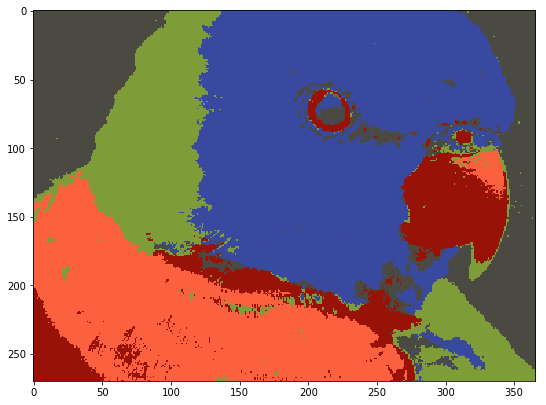

In [14]:
##### Visualization of GMM with EM - Image Segmentation #####
K = 5

image_file = 'images/bird_color_24.png' # Image path
original_image_matrix = image_to_matrix(image_file) # Save original image
image_matrix = original_image_matrix.reshape(-1,3) # collapse the dimension

start = time.time()
_, best_seg = best_segment(image_matrix, K, iters = 10)
end = time.time()
print('Time collapes:', (end-start))

new_image = best_seg.reshape(*original_image_matrix.shape) # reshape collapsed matrix to original size
# Show the image
plt.figure(None,figsize=(9,12))
plt.imshow(new_image)
plt.show()

---

## 3. Improve the performance of Gaussian mixture model

**Two Methods are implemented to achive the performance improvement: **

1) Use K-means algo (unsupervised learning) to improve the initialization step instead of random initialization.

2) Try other convergence condition.


In [45]:
def improved_initialization(X,k):
    """
    Initialize the training process by setting each
    component mean using some algorithm that
    you think might give better means to start with,
    based on the mean calculate covariance matrices,
    and set each component mixing coefficient (PIs)
    to a uniform values
    (e.g. 4 components -> [0.25,0.25,0.25,0.25]).
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    
    returns:
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1 
    """

    # First pick random means to start with
    row, col = X.shape
    idx = np.arange(row)
    np.random.shuffle(idx)
    
    MU = X[idx[:k], :]
    PI = np.repeat(1/k, k)
    
    # Run K-means itr times and calc loglikelihood each time
    likelihood_max = -np.inf
    MU_best = MU.copy()
    SIGMA_best = np.zeros((k, col, col))
    
    i = 0
    itr = 20
    while i <= itr:
        # Update means
        MU, _ = k_means_step(X, k, MU)
        
        # Calc sigma
        MU = np.expand_dims(MU, axis=1)    # (k*n) --> (k*1*n)
        SIGMA = (1/row) * np.matmul(np.transpose((np.tile(X, (k,1)).reshape(k, row, col) - MU), axes=(0,2,1)), 
                                    (np.tile(X, (k,1)).reshape(k, row, col) - MU))     # (m*n) --> (k*m*n)
        likelihood_tmp = likelihood(X, PI, MU, SIGMA, k)
        
        # Pick the one with highest likelihood
        if likelihood_tmp > likelihood_max:
            likelihood_max = likelihood_tmp
            MU_best = MU.reshape(k, col).copy()
            SIGMA_best = SIGMA.copy()
        
        i += 1
    
    
    return MU_best, SIGMA_best, PI


In [46]:
def new_convergence_function(previous_variables, new_variables, conv_ctr,
                             conv_ctr_cap=10):
    """
    Convergence function based on parameters:
    when all variables vary by less than 10% from the previous
    iteration's variables, increase the convergence counter.

    params:

    previous_variables = [numpy.ndarray[float]]
                         containing [means, variances, mixing_coefficients]
    new_variables = [numpy.ndarray[float]]
                    containing [means, variances, mixing_coefficients]
    conv_ctr = int
    conv_ctr_cap = int

    return:
    conv_ctr = int
    converged = boolean
    """

    # Calc each param %age change use element-wise calculation
    tf_cov_all = []
    for para_i in range(len(previous_variables)):
        chg_tmp = abs(np.divide(np.subtract(new_variables[para_i], previous_variables[para_i]), 
                                previous_variables[para_i]))
        tf_cov_parai = np.max(chg_tmp) <= 0.05
        tf_cov_all.append(tf_cov_parai)
    
    # Make sure all para %age change is <= 5% for 10 consecutive times...
    if np.all(tf_cov_all):
        conv_ctr += 1
    else:
        conv_ctr = 0
    
    return conv_ctr, conv_ctr > conv_ctr_cap
    
    
def train_model_improved(X, k, convergence_function, initial_values = None):
    """
    Train the mixture model using the 
    expectation-maximization algorithm. 
    Which is an interative execution of
    the E and M steps from above.
    Convergence is reached when convergence_function
    returns terminate as True,
    see default convergence_function example 
    in `helper_functions.py`

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    convergence_function = func
    initial_values = None or (MU, SIGMA, PI)

    params:
    returns:
    new_MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    new_SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    new_PI = numpy.ndarray[float] - k x 1
    responsibility = numpy.ndarray[numpy.ndarray[float]] - k x m
    """
    # This is single new_convergence_function condition: 
#     if initial_values is None:
#         initial_values = improved_initialization(X, k)
    
#     MU, SIGMA, PI = initial_values
#     para = [MU, SIGMA, PI]
#     #loglike  = 0
#     conv_ctr = 0
#     tf_conv  = False
    
#     while (tf_conv==False):
#         #print('Converge counter: ', conv_ctr)
#         #loglike_pre = loglike
#         para_pre = para.copy()
#         r = E_step(X, MU, SIGMA, PI, k)
#         MU, SIGMA, PI = M_step(X, r, k)
#         para = [MU, SIGMA, PI]
#         #loglike = likelihood(X, PI, MU, SIGMA, k)
        
#         conv_ctr, tf_conv = new_convergence_function(para_pre, para, conv_ctr)
        
#     return MU, SIGMA, PI, r    
    
    
    # Following applies both new_convergence_function & default_convergence (both para chg and loglikelihood chg)
    if initial_values is None:
        initial_values = improved_initialization(X, k)
    
    MU, SIGMA, PI = initial_values
    para = [MU, SIGMA, PI]
    loglike  = 0
    conv_ctr     = 0
    conv_ctr_new = 0
    tf_conv     = False
    tf_conv_new = False
    
    while (tf_conv==False) or (tf_conv_new==False):
        #print('Converge counter: ', conv_ctr)
        loglike_pre = loglike
        para_pre = para.copy()
        
        r = E_step(X, MU, SIGMA, PI, k)
        MU, SIGMA, PI = M_step(X, r, k)
        
        para = [MU, SIGMA, PI]
        loglike = likelihood(X, PI, MU, SIGMA, k)
        
        conv_ctr_new, tf_conv_new = new_convergence_function(para_pre, para, conv_ctr_new)
        conv_ctr, tf_conv = default_convergence(loglike_pre, loglike, conv_ctr)
        
    return MU, SIGMA, PI, r
    

In [1]:
# DON'T RUN THIS CELL IT WILL THROW AN ERROR
# IF YOU ACCIDENTALL RUN IT, IT'S OK, YOU CAN IGNORE THE ERRORS
import numpy as np
from .helper_functions import *

ModuleNotFoundError: No module named '__main__.helper_functions'; '__main__' is not a package

## This is the End.